<a href="https://colab.research.google.com/github/Sarith99/ML_Courses_Practicals/blob/main/Lesson_07_saving_and_loading_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Saving and Loading Models

In this tutorial we will learn how we can take a trained model, save it, and then load it back to keep training it or use it to perform inference. In particular, we will use transfer learning to train a classifier to classify images of cats and dogs, just like we did in the previous lesson. We will then take our trained model and save it as an HDF5 file, which is the format used by Keras. We will then load this model, use it to perform predictions, and then continue to train the model. Finally, we will save our trained model as a TensorFlow SavedModel and then we will download it to a local disk, so that it can later be used for deployment in different platforms.

# Imports

In this Colab we will use the TensorFlow 2.0 Beta version. 

In [1]:
!pip install -U tensorflow_hub
!pip install -U tensorflow_datasets

     |████████████████████████████████| 4.2 MB 5.2 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import layers

# Part 1: Load the Cats vs. Dogs Dataset

There was an error in Cats vs Dogs datsets.

In [3]:
(train_examples, validation_examples), info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

num_training_examples = len(train_examples)
num_validation_examples = len(validation_examples)

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [4]:
print('Total No. of Classes: {}'.format(num_classes))
print('Total No. of Training Images: {}'.format(num_training_examples))
print('Total No. of Validation Images: {}'.format(num_validation_examples))

Total No. of Classes: 5
Total No. of Training Images: 2569
Total No. of Validation Images: 1101


In [5]:
BATCH_SIZE = 32
IMAGE_RES = 224

def format_image(image,label):
  # `hub` image modules expect their data normalized to the [0,1] range.
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

num_examples = info.splits['train'].num_examples

train_batches = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

# Part 2: Transfer Learning with TensorFlow Hub

In [6]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [7]:
feature_extractor.trainable = False

## Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [8]:
model = tf.keras.Sequential([
                             feature_extractor,
                             layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the model

We now train this model like any other, by first calling `compile` followed by `fit`.

In [9]:
EPOCHS = 3

model.compile(
    optimizer='adam',
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = model.fit(train_batches,
                    epochs = EPOCHS,
                    validation_data = validation_batches)

Epoch 1/3
81/81 [==============================] - 26s 146ms/step - loss: 0.6987 - accuracy: 0.7528 - val_loss: 0.4401 - val_accuracy: 0.8411
Epoch 2/3
81/81 [==============================] - 4s 51ms/step - loss: 0.3626 - accuracy: 0.8832 - val_loss: 0.3523 - val_accuracy: 0.8783
Epoch 3/3
81/81 [==============================] - 4s 51ms/step - loss: 0.2894 - accuracy: 0.9089 - val_loss: 0.3294 - val_accuracy: 0.8910


## Check the predictions

Get the ordered list of class names.

In [10]:
class_names = np.array(info.features['label'].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [11]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

['tulips' 'daisy' 'dandelion' 'sunflowers' 'tulips' 'sunflowers' 'tulips'
 'tulips' 'roses' 'daisy' 'dandelion' 'dandelion' 'daisy' 'roses'
 'sunflowers' 'dandelion' 'tulips' 'roses' 'tulips' 'sunflowers' 'roses'
 'sunflowers' 'sunflowers' 'dandelion' 'dandelion' 'dandelion' 'dandelion'
 'roses' 'sunflowers' 'roses' 'dandelion' 'dandelion']


In [12]:
print("Labels: {}".format(label_batch))
print("Predicted Labels: {}".format(predicted_ids))

Labels: [2 1 0 3 2 3 2 0 4 1 0 0 1 4 3 3 1 4 2 3 4 3 3 0 0 0 0 4 3 4 0 0]
Predicted Labels: [2 1 0 3 2 3 2 2 4 1 0 0 1 4 3 0 2 4 2 3 4 3 3 0 0 0 0 4 3 4 0 0]


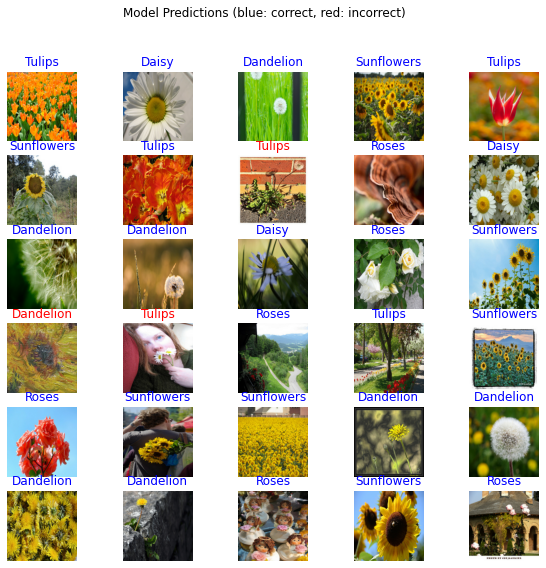

In [13]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(),color=color)
  plt.axis('off')
_ = plt.suptitle("Model Predictions (blue: correct, red: incorrect)")

# Part 3: Save as Keras `.h5` model

Now that we've trained the model,  we can save it as an HDF5 file, which is the format used by Keras. Our HDF5 file will have the extension `.h5`, and it's name will correpond to the current time stamp.

In [14]:
t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1653175631.h5


In [15]:
!ls

1653175631.h5  sample_data


 You can later recreate the same model from this file, even if you no longer have access to the code that created the model.

This file includes:

- The model's architecture
- The model's weight values (which were learned during training)
- The model's training config (what you passed to `compile`), if any
- The optimizer and its state, if any (this enables you to restart training where you left off)

# Part 4:  Load the Keras `.h5` Model

We will now load the model we just saved into a new model called `reloaded`. We will need to provide the file path and the `custom_objects` parameter. This parameter tells keras how to load the `hub.KerasLayer` from the `feature_extractor` we used for transfer learning.

In [16]:
reloaded =  tf.keras.models.load_model(
    export_path_keras,
    # `custom_objects` tells keras how to load a `hub.KerasLayer`
    custom_objects={'KerasLayer': hub.KerasLayer})

reloaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [17]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [18]:
(abs(result_batch - reloaded_result_batch)).max()

0.0

# Keep Training

Besides making predictions, we can also take our `reloaded` model and keep training it. To do this, you can just train the `reloaded` as usual, using the `.fit` method.

In [19]:
EPOCHS = 3
history = reloaded.fit(train_batches,
                       epochs = EPOCHS,
                       validation_data = validation_batches)

Epoch 1/3
81/81 [==============================] - 7s 58ms/step - loss: 0.2386 - accuracy: 0.9284 - val_loss: 0.3008 - val_accuracy: 0.9019
Epoch 2/3
81/81 [==============================] - 4s 51ms/step - loss: 0.2044 - accuracy: 0.9424 - val_loss: 0.3065 - val_accuracy: 0.8919
Epoch 3/3
81/81 [==============================] - 4s 51ms/step - loss: 0.1832 - accuracy: 0.9510 - val_loss: 0.2906 - val_accuracy: 0.9037


# Part 5: Export as SavedModel

You can also export a whole model to the TensorFlow SavedModel format. SavedModel is a standalone serialization format for Tensorflow objects, supported by TensorFlow serving as well as TensorFlow implementations other than Python. A SavedModel contains a complete TensorFlow program, including weights and computation. It does not require the original model building code to run, which makes it useful for sharing or deploying (with TFLite, TensorFlow.js, TensorFlow Serving, or TFHub).

The SavedModel files that were created contain:

* A TensorFlow checkpoint containing the model weights.
* A SavedModel proto containing the underlying Tensorflow graph. Separate graphs are saved for prediction (serving), train, and evaluation. If the model wasn't compiled before, then only the inference graph gets exported.
* The model's architecture config, if available.


Let's save our original `model` as a TensorFlow SavedModel. To do this we will use the `tf.saved_model.save()` function. This functions takes in the model we want to save and the path to the folder where we want to save our model. 

This function will create a folder where you will find an `assets` folder, a `variables` folder, and the `saved_model.pb` file. 

In [20]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

./1653175651
INFO:tensorflow:Assets written to: ./1653175651/assets


INFO:tensorflow:Assets written to: ./1653175651/assets


In [21]:
!ls {export_path_sm}

assets	saved_model.pb	variables


# Part 6: Load SavedModel

Now, let's load our SavedModel and use it to make predictions. We use the `tf.saved_model.load()` function to load our SavedModels. The object returned by `tf.saved_model.load` is 100% independent of the code that created it.

In [22]:
reloaded_sm = tf.saved_model.load(export_path_sm)

Now, let's use the `reloaded_sm` (reloaded SavedModel) to make predictions on a batch of images.

In [23]:
reloaded_sm_result_batch = reloaded_sm(image_batch, training = False).numpy()

We can check that the reloaded SavedModel and the previous model give the same result.

In [24]:
(abs(result_batch - reloaded_sm_result_batch)).max()

0.0

# Part 7: Loading the SavedModel as a Keras Model

The object returned by `tf.saved_model.load` is not a Keras object (i.e. doesn't have `.fit`, `.predict`, `.summary`, etc. methods). Therefore, you can't simply take your `reloaded_sm` model and keep training it by running `.fit`. To be able to get back a full keras model from the Tensorflow SavedModel format we must use the `tf.keras.models.load_model` function. This function will work the same as before, except now we pass the path to the folder containing our SavedModel.

In [30]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)
model.save(export_path_sm)

./1653176723
INFO:tensorflow:Assets written to: ./1653176723/assets


INFO:tensorflow:Assets written to: ./1653176723/assets


In [31]:
reload_sm_keras = tf.keras.models.load_model(
  export_path_sm,
  custom_objects={'KerasLayer': hub.KerasLayer})

reload_sm_keras.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


Now, let's use the `reloaded_sm)keras` (reloaded Keras model from our SavedModel) to make predictions on a batch of images.

In [32]:
result_batch = model.predict(image_batch)
reloaded_sm_keras_result_batch = reload_sm_keras.predict(image_batch)

We can check that the reloaded Keras model and the previous model give the same result.

In [33]:
(abs(result_batch - reloaded_sm_keras_result_batch)).max()

0.0

# Part 8:  Download your model

You can download the SavedModel to your local disk by creating a zip file. We wil use the `-r` (recursice) option to zip all subfolders. 

In [35]:
!zip -r model.zip {export_path_sm}

  adding: 1653176723/ (stored 0%)
  adding: 1653176723/keras_metadata.pb (deflated 80%)
  adding: 1653176723/variables/ (stored 0%)
  adding: 1653176723/variables/variables.index (deflated 78%)
  adding: 1653176723/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: 1653176723/saved_model.pb (deflated 92%)
  adding: 1653176723/assets/ (stored 0%)


In [36]:
!ls

1653175631.h5  1653175651  1653175662  1653176723  model.zip  sample_data


In [37]:
try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>